In [1]:
!pip install webcolors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.preprocessing import StandardScaler

In [4]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
customers = pd.read_csv('/content/drive/MyDrive/Data For Colab/Ecommerce Customers.txt')

In [7]:
customers.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [8]:
customers.shape

(500, 8)

In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Email                 500 non-null    object 
 1   Address               500 non-null    object 
 2   Avatar                500 non-null    object 
 3   Avg. Session Length   500 non-null    float64
 4   Time on App           500 non-null    float64
 5   Time on Website       500 non-null    float64
 6   Length of Membership  500 non-null    float64
 7   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5), object(3)
memory usage: 31.4+ KB


In [10]:
customers.describe() #looks okay

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


<AxesSubplot:ylabel='Frequency'>

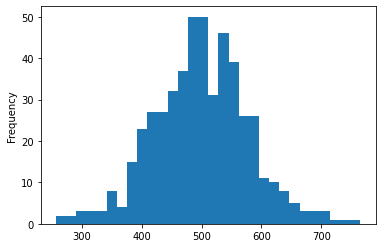

In [11]:
# check Y distribution 

customers['Yearly Amount Spent'].plot(kind='hist',bins=30)

Avg. Session Length


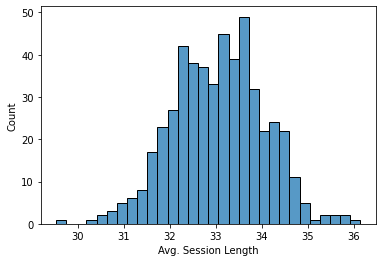



Time on App


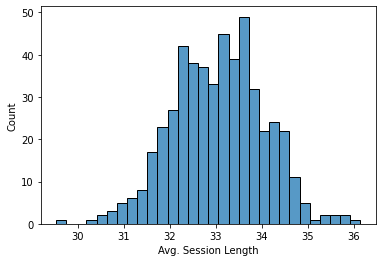



Time on Website


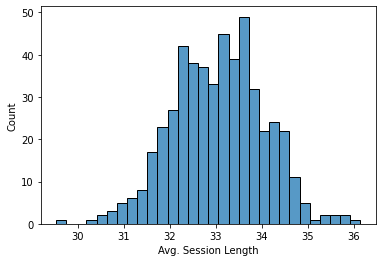



Length of Membership


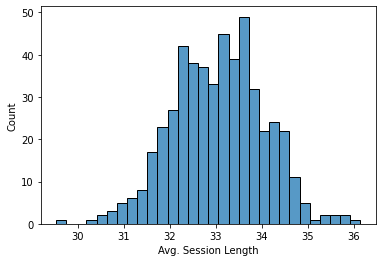

In [12]:
# check X distribution

for col in customers.columns[3:7]:
  print('\033[1m' + col)
  sns.histplot(customers['Avg. Session Length'],bins=30)
  plt.show()
  print('\n')

In [13]:
# All feature are normally distributed..excellent!!

Avg. Session Length


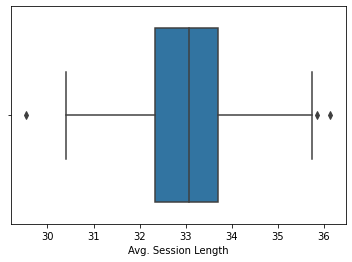



Time on App


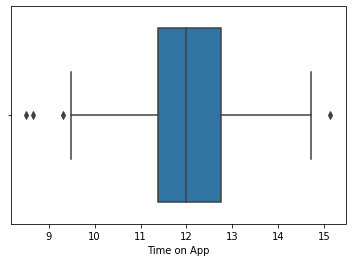



Time on Website


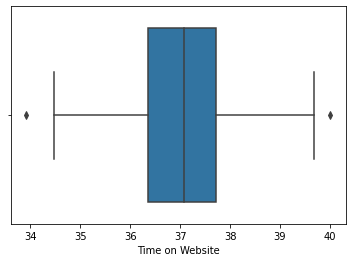



Length of Membership


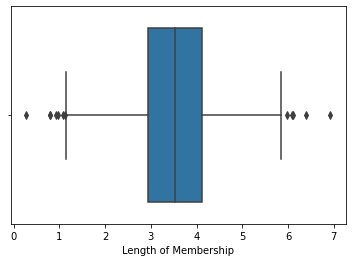

In [14]:
# check outliers using boxplot

for col in customers.columns[3:7]:
  print('\033[1m' + col)
  sns.boxplot(data= customers, x= col)
  plt.show()
  print('\n')

Avg. Session Length


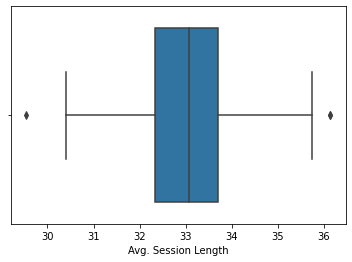



Time on App


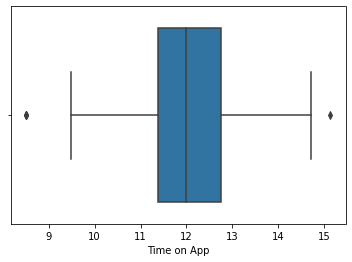



Time on Website


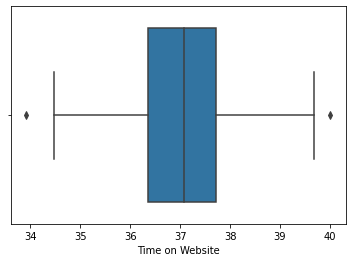



Length of Membership


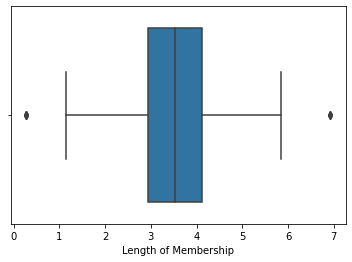

In [15]:
# outliers handling

for col in customers.columns[3:7]:
  Q3 = np.percentile(customers[col],75)
  Q1 = np.percentile(customers[col],25)
  customers[col] = np.where(customers[col]>Q3+1.5*(Q3-Q1),customers[col].max(),np.where(customers[col]<Q1-1.5*(Q3-Q1),customers[col].min(),customers[col]))
  print('\033[1m' + col)
  sns.boxplot(data= customers, x= col)
  plt.show()
  print('\n')

In [16]:
# check for null values

pd.DataFrame(customers.iloc[:,:-1].isnull().sum()*100/customers.shape[0],columns=['count']).sort_values('count',ascending=False) #No Null values is found

,count
Email,0.0
Address,0.0
Avatar,0.0
Avg. Session Length,0.0
Time on App,0.0
Time on Website,0.0
Length of Membership,0.0


In [17]:
# EDA for bivariate analysis

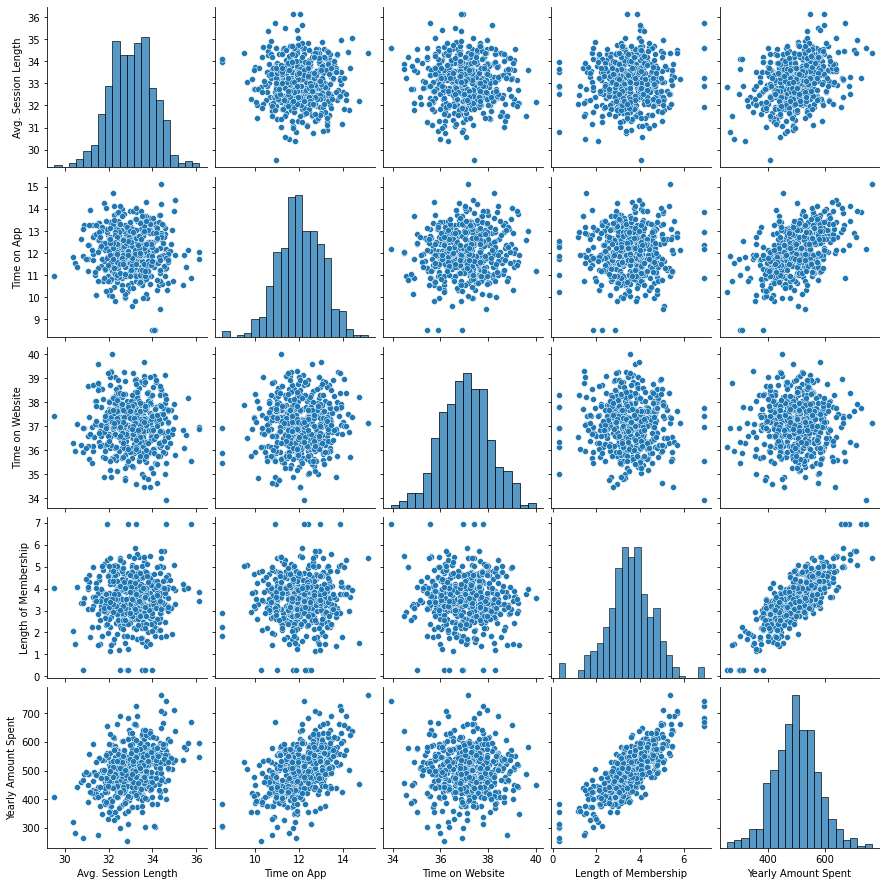

In [18]:
sns.pairplot(customers.iloc[3:])
plt.show()
# don't find any collinearity
# positive regression of 5(Y) with 1,2,4

In [19]:
# Create new email type feature from email ids

customers['Email_Type'] = customers.Email.apply(lambda x: x.split('@')[1])
customers['Email_Type'] = customers.Email_Type.apply(lambda x: x.split('.')[0].strip())
customers['Email_Type'] = np.where(customers.Email_Type.isin(['gmail','hotmail','yahoo']),customers.Email_Type,'Others')

In [20]:
customers['Email_Type'].value_counts()

Others     250
hotmail     87
gmail       87
yahoo       76
Name: Email_Type, dtype: int64

In [21]:
# Create States from Adress 

customers['State'] = pd.Series(dtype='int')
for i in range(len(customers)):
  try:
    customers.iloc[i,-1] = customers.Address.str.split(',')[i][1].strip()[0:2]
  except:  
    customers.iloc[i,-1] = customers.Address.str.split('PO')[i][1].strip()[0:2]

In [22]:
customers['State'] = customers.State.str.upper()
customers.State.unique()

array(['MI', 'CA', 'DC', 'OH', 'PR', 'MN', 'WV', 'AP', 'SD', 'BO', 'WY',
       'AA', 'MO', 'MP', 'ND', 'GA', 'PW', 'MT', 'KY', 'VI', 'TX', 'MS',
       'SC', 'WA', 'NJ', 'NH', 'ME', 'ID', 'TN', 'AK', 'DE', 'AE', 'FM',
       'HI', 'KS', 'NC', 'UT', 'AL', 'LA', 'NE', 'OR', 'CT', 'MA', 'IN',
       'AZ', 'MH', 'NY', 'CO', 'IA', 'GU', 'AS', 'RI', 'VA', 'MD', 'OK',
       'WI', 'VT', 'FL', 'IL', 'NV', 'PA', 'NM', 'AR'], dtype=object)

In [23]:
import webcolors

def color_to_rgb(color):
    try:
        rgb = webcolors.name_to_rgb(color)
    except ValueError:
        # If the named color is not recognized, return None
        return None
    return rgb

In [24]:
customers['Avatar2'] = customers.Avatar.apply(lambda x: 'Red' if np.argmax(list(color_to_rgb(x)))==0 else 'Non-Red')

In [25]:
customers.Avatar2.unique()

array(['Red', 'Non-Red'], dtype=object)

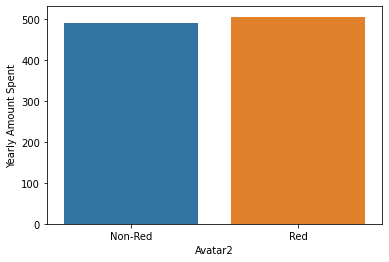

In [26]:
AmountSpent_Avatar = customers.groupby('Avatar2')['Yearly Amount Spent'].mean().reset_index()
sns.barplot(data=AmountSpent_Avatar,x='Avatar2',y='Yearly Amount Spent')
plt.show()

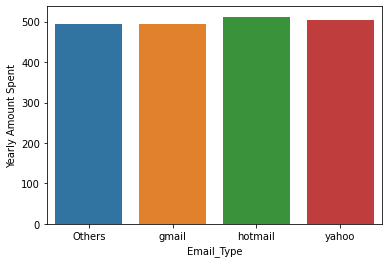

In [27]:
AmountSpent_EmailType = customers.groupby('Email_Type')['Yearly Amount Spent'].mean().reset_index()
sns.barplot(data=AmountSpent_EmailType,x='Email_Type',y='Yearly Amount Spent')
plt.show()

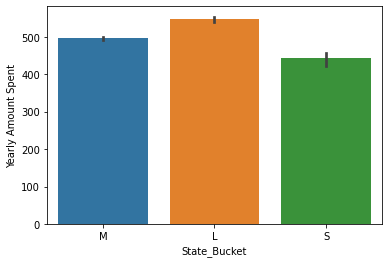

In [28]:
AmountSpent_State = customers.groupby('State')['Yearly Amount Spent'].mean().reset_index()
AmountSpent_State['State_Bucket'] = np.where(AmountSpent_State['Yearly Amount Spent']<470,'S',np.where(AmountSpent_State['Yearly Amount Spent']<525,'M','L'))
sns.barplot(data=AmountSpent_State,x='State_Bucket',y='Yearly Amount Spent')
plt.show()

In [29]:
customers = customers.merge(AmountSpent_State[['State','State_Bucket']],how='left',on='State')

In [30]:
customers.columns

Index(['Email', 'Address', 'Avatar', 'Avg. Session Length', 'Time on App',
       'Time on Website', 'Length of Membership', 'Yearly Amount Spent',
       'Email_Type', 'State', 'Avatar2', 'State_Bucket'],
      dtype='object')

In [31]:
customers_final = pd.get_dummies(customers[['Avg. Session Length', 'Time on App',
       'Time on Website', 'Length of Membership','Email_Type', 'State_Bucket', 'Avatar2']])

In [32]:
customers_final.head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Email_Type_Others,Email_Type_gmail,Email_Type_hotmail,Email_Type_yahoo,State_Bucket_L,State_Bucket_M,State_Bucket_S,Avatar2_Non-Red,Avatar2_Red
0,34.497268,12.655651,39.577668,4.082621,1,0,0,0,0,1,0,0,1
1,31.926272,11.109461,37.268959,2.664034,0,0,1,0,0,1,0,1,0
2,33.000915,11.330278,37.110597,4.104543,0,0,0,1,0,1,0,0,1
3,34.305557,13.717514,36.721283,3.120179,0,1,0,0,1,0,0,0,1
4,33.330673,12.795189,37.536653,4.446308,1,0,0,0,0,1,0,1,0


In [33]:
# Feature Selection

from sklearn.linear_model import Lasso

X = customers_final
y = customers['Yearly Amount Spent']

In [34]:
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)

Lasso(alpha=0.1)

In [35]:
coef = pd.Series(lasso.coef_, index=X.columns).sort_values(ascending=False)
coef

Length of Membership    58.599968
Time on App             37.981163
Avg. Session Length     25.473482
State_Bucket_L           2.353968
Time on Website          0.146736
Email_Type_Others        0.000000
Email_Type_hotmail       0.000000
Email_Type_yahoo        -0.000000
State_Bucket_M           0.000000
Avatar2_Red              0.000000
Email_Type_gmail        -0.064105
State_Bucket_S          -0.223431
Avatar2_Non-Red         -0.468109
dtype: float64

In [36]:
X_subset = X.iloc[:,:4]
X_subset.head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership
0,34.497268,12.655651,39.577668,4.082621
1,31.926272,11.109461,37.268959,2.664034
2,33.000915,11.330278,37.110597,4.104543
3,34.305557,13.717514,36.721283,3.120179
4,33.330673,12.795189,37.536653,4.446308


In [37]:
scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(X_subset),columns=X_subset.columns)
X2 = pd.concat([temp,X.iloc[:,4:]],axis=1)

In [38]:
scaler.fit_transform(X)

array([[ 1.45335558,  0.60544663,  2.49358859, ..., -0.27011363,
        -0.9530986 ,  0.9530986 ],
       [-1.13516621, -0.94162982,  0.20655573, ..., -0.27011363,
         1.04920939, -1.04920939],
       [-0.0531978 , -0.72068595,  0.04968115, ..., -0.27011363,
        -0.9530986 ,  0.9530986 ],
       ...,
       [-0.40974998, -0.55145803,  1.26018697, ..., -0.27011363,
        -0.9530986 ,  0.9530986 ],
       [ 0.2705807 ,  0.34106706, -0.21829075, ..., -0.27011363,
         1.04920939, -1.04920939],
       [ 0.66674286,  0.36846808, -1.27732288, ..., -0.27011363,
        -0.9530986 ,  0.9530986 ]])

In [39]:
X2.head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Email_Type_Others,Email_Type_gmail,Email_Type_hotmail,Email_Type_yahoo,State_Bucket_L,State_Bucket_M,State_Bucket_S,Avatar2_Non-Red,Avatar2_Red
0,1.453356,0.605447,2.493589,0.529946,1,0,0,0,0,1,0,0,1
1,-1.135166,-0.941630,0.206556,-0.834186,0,0,1,0,0,1,0,1,0
2,-0.053198,-0.720686,0.049681,0.551027,0,0,0,1,0,1,0,0,1
3,1.260338,1.667918,-0.335978,-0.395551,0,1,0,0,1,0,0,0,1
4,0.278808,0.745064,0.471737,0.879673,1,0,0,0,0,1,0,1,0


In [40]:
# Forward Selection

X3 = X2[['Length of Membership','Time on App','Avg. Session Length','Time on Website']]

In [41]:
# Possible features - 'Length of Membership','Time on App','Avg. Session Length','Time on Website'
# Another Possible features - 'Length of Membership','Time on App','Avg. Session Length','State_Bucket_L','State_Bucket_S','Avatar2_Red'

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X3,y,test_size=0.2,random_state=42)

model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [43]:
coef_lr = pd.concat([pd.Series(model.feature_names_in_),pd.Series(model.coef_)],axis=1)
coef_lr.columns = ['Feature','Score']
coef_lr.sort_values('Score',ascending=False)

,Feature,Score
0,Length of Membership,61.275529
1,Time on App,38.434082
2,Avg. Session Length,25.209677
3,Time on Website,0.052512


In [44]:
y_pred = model.predict(X_train)
print(mean_squared_error(y_train,y_pred))

133.30130585008618


In [45]:
y_pred_test = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

MAE: 8.752635472890686
MSE: 121.66085182570811
RMSE: 11.02999781621502


Text(0, 0.5, 'Predicted Y')

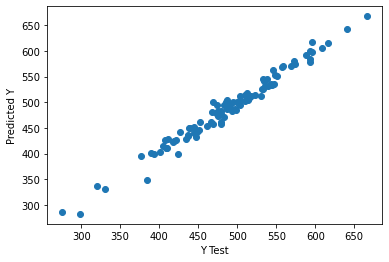

In [46]:
plt.scatter(y_test,y_pred_test)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


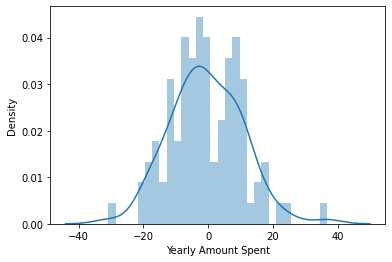

In [47]:
# Residual distribution 

sns.distplot((y_test-y_pred_test),bins=30);

In [48]:
error_compare = (y_test-y_pred_test)*100/y_test
(error_compare<=5).sum()*100/len(error_compare)

97.0